## **Lab 8**

In this lab, we will learn how to compute the optical flow of a sequence of video frames using the Lucas-Kanade differential method. We have provided two datasets (Hydrangea and RubberWhale) along with the python notebook for this lab. Please place them in the same directory as your jupyter notebook.

In [1]:
import cv2
import numpy as np

from glob import glob
from typing import List
from scipy import signal as sig
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm
from matplotlib import pyplot as plt
plt.ioff()

In [2]:
# data taken from https://vision.middlebury.edu/flow/data/
# Get frames in order
frames_pths = sorted(glob('./RubberWhale/*'))

In [3]:
frames_pths

['./RubberWhale/frame07.png',
 './RubberWhale/frame08.png',
 './RubberWhale/frame09.png',
 './RubberWhale/frame10.png',
 './RubberWhale/frame11.png',
 './RubberWhale/frame12.png',
 './RubberWhale/frame13.png',
 './RubberWhale/frame14.png']

In [4]:
frames = [cv2.imread(pth) for pth in frames_pths]

In [5]:
def displayImage(img: np.array, window_name: str = "Display window")-> None:
    '''
        Display an image in a numpy array using cv2
        
        
        :param img: Image to display stored in a numpy array
        :param window_name: Name to display on the window
    '''
    
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    cv2.imshow(window_name, img)
    # Wait for a key event infinitely
    cv2.waitKey(0)

    # Close all open windows  
    cv2.destroyAllWindows()  
    # For mac users, uncomment the following line
    cv2.waitKey(1)

In [ ]:
def displayFrames(frames: List[np.array], window_name: str = "Display window")-> None:
    '''
        Display frames stored in a list using cv2
        
        :param frames:  Frames to display stored in a list
        :param window_name: Name to display on the window
    '''
    
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    
    for frame in frames:
        cv2.imshow(window_name, frame)
        # Wait for a key event infinitely
        cv2.waitKey(0)
        
    
    # Close all open windows  
    cv2.destroyAllWindows()  
    # For mac users, uncomment the following line
    cv2.waitKey(1)
    

In [21]:
displayFrames(frames)

In [ ]:

def ColorFlow(flow: np.array)->np.array:
    '''
    https://github.com/opencv/opencv/blob/3.4/samples/python/tutorial_code/video/optical_flow/optical_flow_dense.py
    
    The function takes a 2-channel array with optical flow vectors, (u,v) as input, finds their magnitude and 
    direction and color codes the result for better visualization. Direction corresponds to Hue value of the image. 
    Magnitude corresponds to Value plane.
    
    :param flow: Dense optical flow in HxWx2 format
    '''
    
    
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype='uint8')
    hsv[..., 1] = 255
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return bgr


def QuiverFlow(flow:np.array, step: int=5):
    '''
        Plots a quiver plot using the flow vecgtors
        
        :param flow: Dense optical flow in HxWx2 format
        :step: Step size to ignore
    '''
    
    fig = plt.figure()
    plt.quiver(np.arange(0, flow.shape[1], step), np.arange(flow.shape[0], -1, -step), 
               flow[::step, ::step, 0], flow[::step, ::step, 1])
    fig.canvas.draw()
    # flow = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    flow = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    flow = flow.reshape(fig.canvas.get_width_height()[::-1] + (4,))
    flow = flow[..., :3]  #  Only useRGB from RGBA
    # flow = flow.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    return flow


Recall that the Lucas-Kanada method assumes that the flow is essentially constant in a local neighbourhood of the pixel under consideration, and solves the basic optical flow equations for all the pixels in that neighbourhood, by the least squares criterion. To begin, we can formulate the following equations $A$ and $b$ as shown below. Finally, we can compute the solution for $u$ and $v$ as: $(A^T A)^{-1} A^T b $.

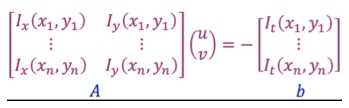

In [17]:

def LucasKanade(img1: np.array, img2: np.array)->np.array:
    '''
    Takes two consecutive frames from a video and computes Optical flow using LucasKanade algorithm.
    
    :param img1: frame at t-1
    :param img2: frame at t
    '''
    
    #Converts BGR images to Grayscale
    toGray = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #

    #Flattens last two dimensions in a 4D array
    flattenLast = lambda img: np.reshape(img, (img.shape[0], img.shape[1], -1))

    # Flattens first two dimension in a 3D array
    flattenFirst = lambda img: np.reshape(img, (-1, img.shape[-1]))

    # Step - 1
    ## Compute the X, Y and time gradients for the images

    ## kernel for x derivative
    dX = np.array([[1, 0, -1]])

    ## Kernel for y derivative
    dY = dX.T

    ## convert images to grayscale and apply gaussian blur (hint: use cv2.GaussianBlur with a kernel size of 5 and horizontal std of 0.5)
    img1 = toGray(img1) # convert img1 to grayscale
    img2 = toGray(img2) # convert img2 to grayscale
    img1 = cv2.GaussianBlur(img1, (5, 5), 0.5) # smooth img1 with gaussian blur
    img2 = cv2.GaussianBlur(img2, (5, 5), 0.5) # smooth img2 with gaussian blur
    
    ## Get X, Y and t derivatives
    Ix = sig.convolve2d(img2, dX, mode='same')
    Iy = sig.convolve2d(img2, dY, mode='same')
    It = img2-img1
    
    # Step - 2
    # Take a 3x3 region around each pixel and setup the matrices to solve for U and V at each pixel (hint: call the imported sliding_window_view function)

    # Gets Sliding windows of size 3x3 for the dervatives
    Ix = sliding_window_view(Ix, (3, 3)) # Compute derivatives with sliding windows of size 3 x 3 -> [H-2,W-2,3,3]
    Iy = sliding_window_view(Iy, (3, 3)) # Compute derivatives with sliding windows of size 3 x 3
    It = sliding_window_view(It, (3, 3)) # Compute derivatives with sliding windows of size 3 x 3
    
    # Flatten for broadcasting matrix multiplications (hint: call the flattenLast function before the flattenFirst function on each matrix)
    Ix = flattenFirst(flattenLast(Ix)) #->[(H-2)x(W-2), 3X3]
    Iy = flattenFirst(flattenLast(Iy))
    It = flattenFirst(flattenLast(It))

    # Setup the equations
    A = np.stack((Ix, Iy), axis=-1) # stack Ix and Iy -> [(H-2)x(W-2), 9, 2]
    At = np.transpose(A, (0, 2, 1))  # compute transpose of A
    It = It[..., np.newaxis]   # create a new axis at the end
   
    # Step - 3 
    # compute flow for each pixel in the frame,  color it and return
    Ainv = At @ A # computes (A^T)A
    buf = At @ (-It) # computes (A^T)b
    flow = np.linalg.pinv(Ainv) @ buf  # computes final optical flow values (hint: remember to negate your values in buf!)
    flow = np.reshape(flow[:, :, 0], (img1.shape[0]-2, img1.shape[1]-2, 2))
    
    return QuiverFlow(flow)
    # return ColorFlow(flow)
    
    

100%|██████████| 7/7 [00:03<00:00,  2.27it/s]


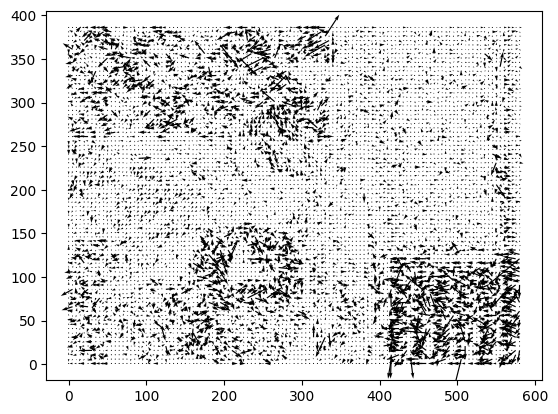

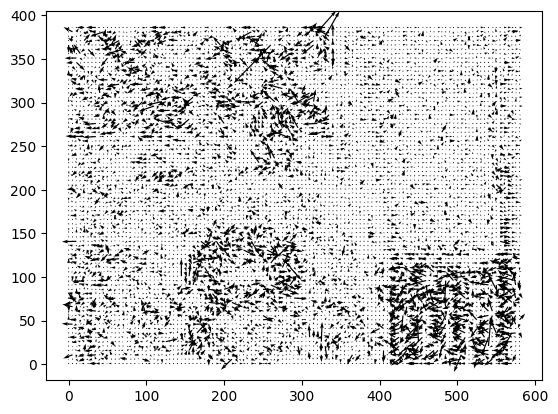

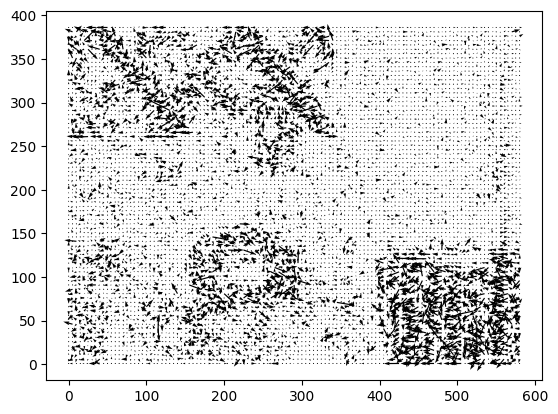

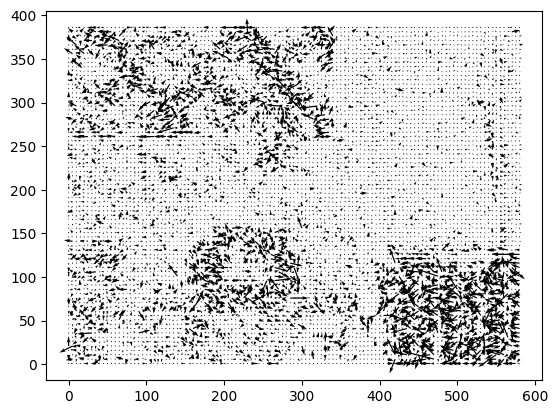

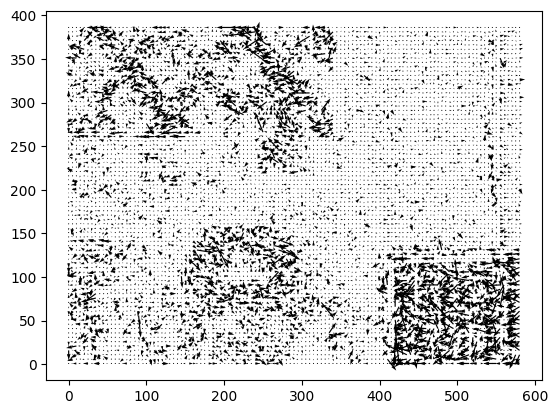

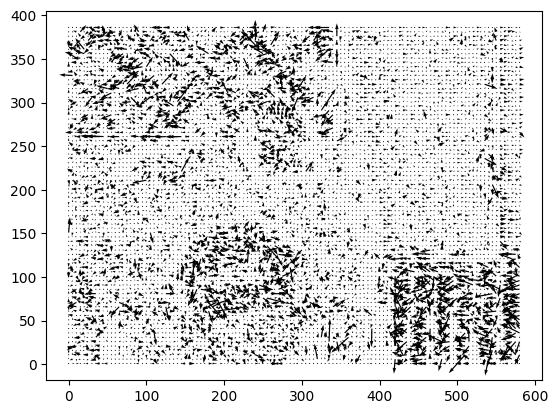

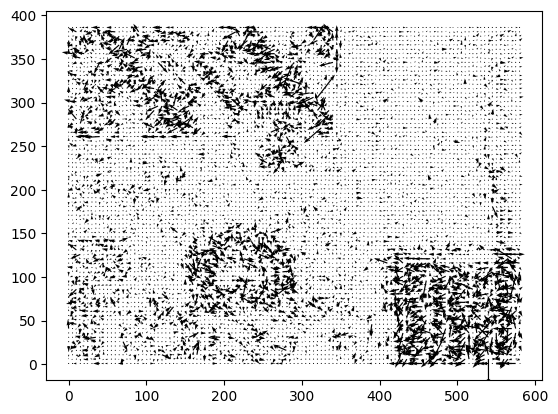

In [20]:
# Compute optical flows with Lucas Kanade

flows = []
for i in tqdm(range(len(frames[:-1]))):
    flows.append(LucasKanade(frames[i], frames[i+1]))

In [12]:
displayFrames(flows)

2025-03-21 13:01:11.540 Python[68248:2317476] error messaging the mach port for IMKCFRunLoopWakeUpReliable
